I analyzed several datasets before choosing this one, but they all turned out to be white noise. Later I remembered what happened to Gamestop actions last month, so I decided to analyze the adjusted closure of the latter. 
I consider a daily analysis and picked a whole year, as time window, to get enough data.

In [1]:
library(ggplot2)
library(TSA)
library(forecast)

GME=read.csv("GME.csv",sep=",");
GME=data.frame(GME$Date,GME$Adj.Close)
dt=as.Date(GME$GME.Date, format="%Y-%m-%d");
X=GME$GME.Adj.Close

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'TSA' was built under R version 3.6.3"
Attaching package: 'TSA'

The following objects are masked from 'package:stats':

    acf, arima

The following object is masked from 'package:utils':

    tar

Warning message:
"package 'forecast' was built under R version 3.6.3"Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Registered S3 methods overwritten by 'forecast':
  method       from
  fitted.Arima TSA 
  plot.Arima   TSA 


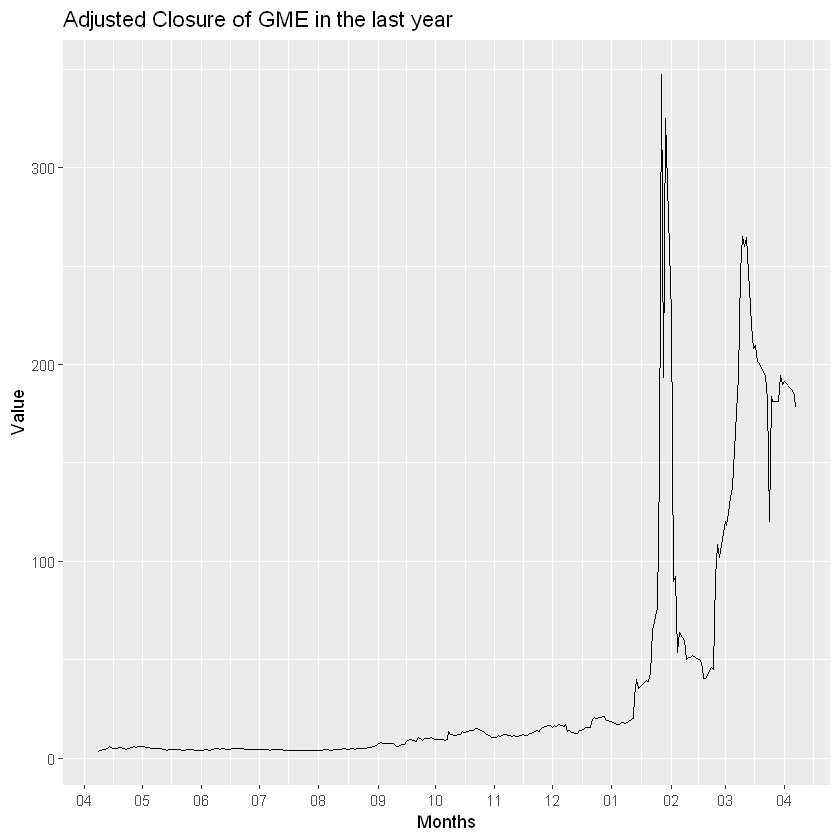

In [2]:
GMEg= ggplot(GME, aes(x = dt, y = X)) + geom_line() +
  labs(title="Adjusted Closure of GME in the last year", x="Months", y="Value") +
  scale_x_date(breaks = pretty(dt,n=10),date_labels = "%m");
GMEg

From the plot we can see that the progression for most of time is stable, from semptember it start growning a bit, untile january where we can see a big spike, and after that it starts moving a lot up and down.

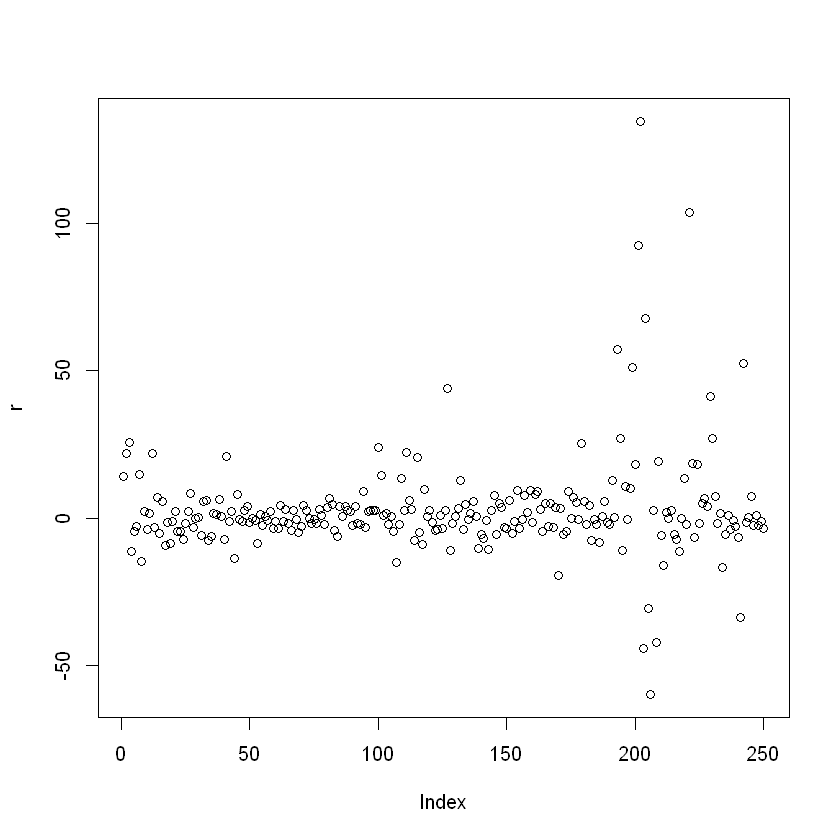

In [3]:
T = length(dt);
r = ((X[2:T]-X[1:(T-1)])/X[1:(T-1)])*100
plot(r)

Here as before we can see that most of time the simple percentage return is near zero. We can see an exception on the last days of the study where it diverges a lot.

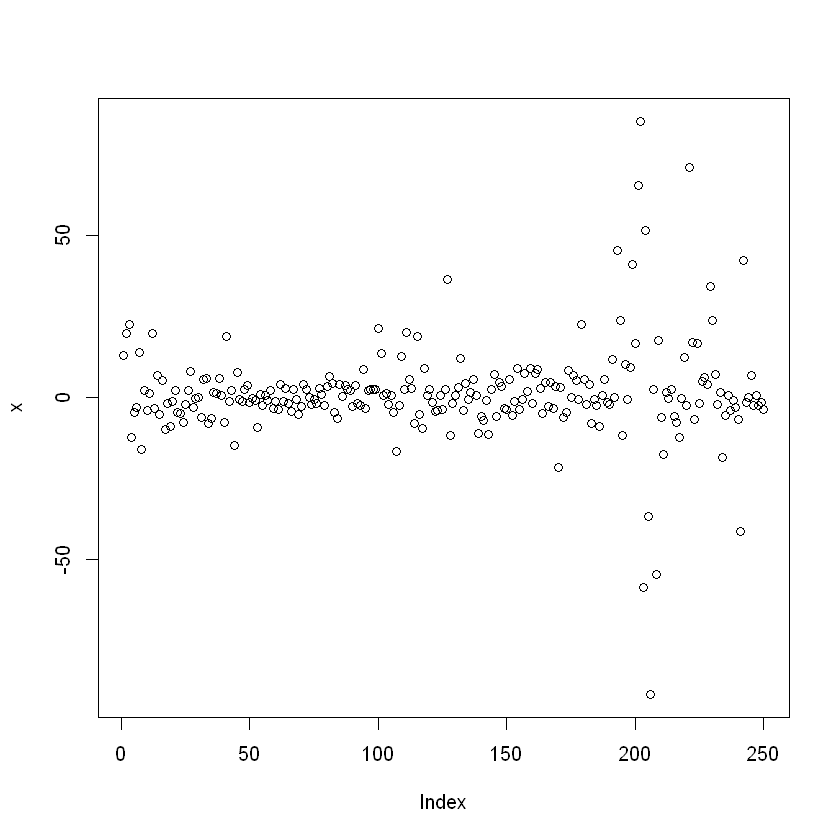

In [6]:
x = diff(log(X))*100
plot(x)

The log return percentage is very similar to the simple one.

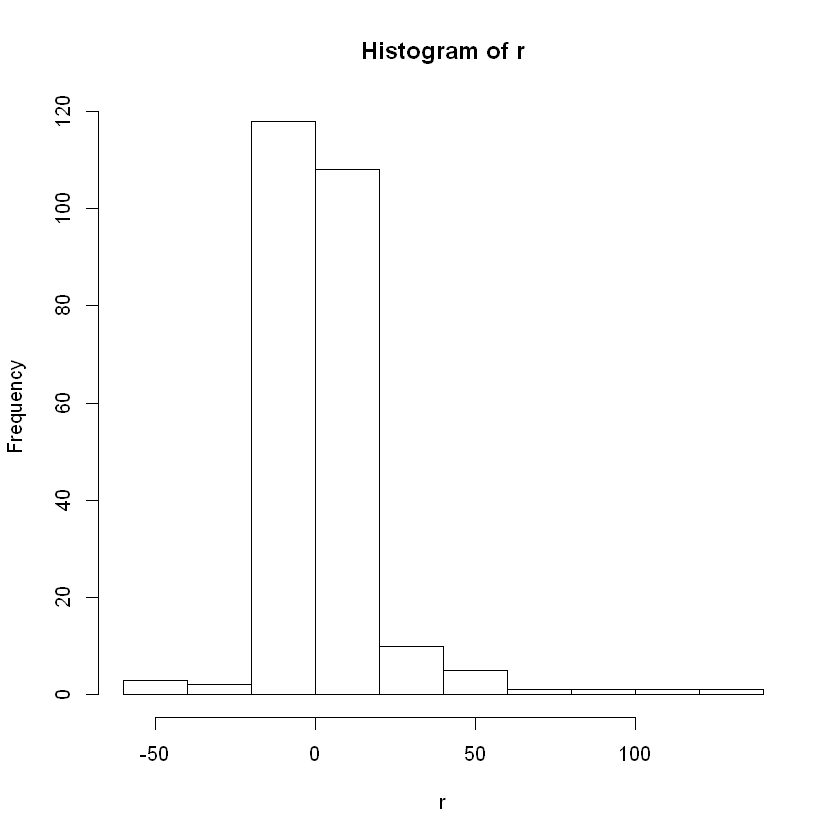

In [14]:
library(fBasics)
hist(r)

In [15]:
basicStats(r)
s1 = skewness(r)[1]; s1
t1 = s1/sqrt(6/length(r))
pv = 2*(1-pnorm(t1))
pv
t.test(x)
normalTest(x,method="jb")

,r
,<dbl>
nobs,250.000000
NAs,0.000000
Minimum,-60.000000
Maximum,134.835802
1. Quartile,-3.347393
3. Quartile,4.757696
Mean,2.832840
Median,0.195741
Sum,708.209952


[1] 3.234629

[1] 0


	One Sample t-test

data:  x
t = 1.6369, df = 249, p-value = 0.1029
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.3215156  3.4854378
sample estimates:
mean of x 
 1.581961 



Title:
 Jarque - Bera Normalality Test

Test Results:
  STATISTIC:
    X-squared: 1734.6067
  P VALUE:
    Asymptotic p Value: < 2.2e-16 

Description:
 Sun Jan 23 17:37:21 2022 by user: Mattia


We can easily see, from the result of the function basicStats, that we the skewness is not zero and that the kurtosis is much bigger that 3. One particular thing, that we can notice from this study, other than the fact that our distribution is not normal having p-value equal to $2.2e-16$, is that the mean is not significally different from zero. This is mainly because, although the mean is equal to 2.832840, the variance is very high.\\
We did this by considering as test for skewness: the null hypothesis equal to $S=0$ and the test statistic: $t=\frac{\hat{S}}{\sqrt{6/T}}\sim \textit{N}(0,1)$.


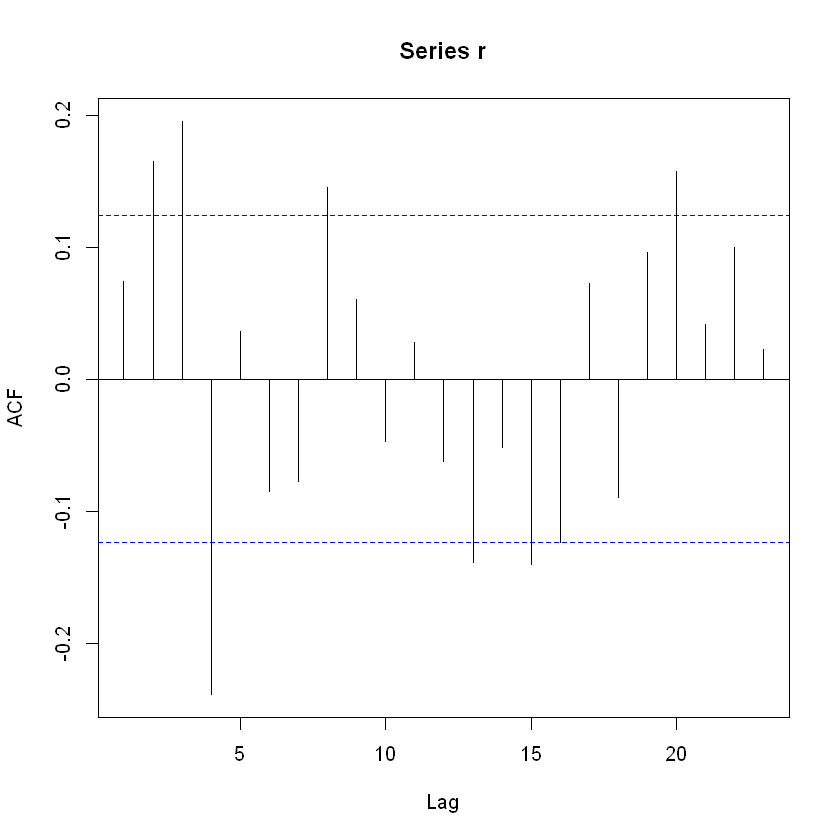

In [11]:
acf(r); #autocorrelation function

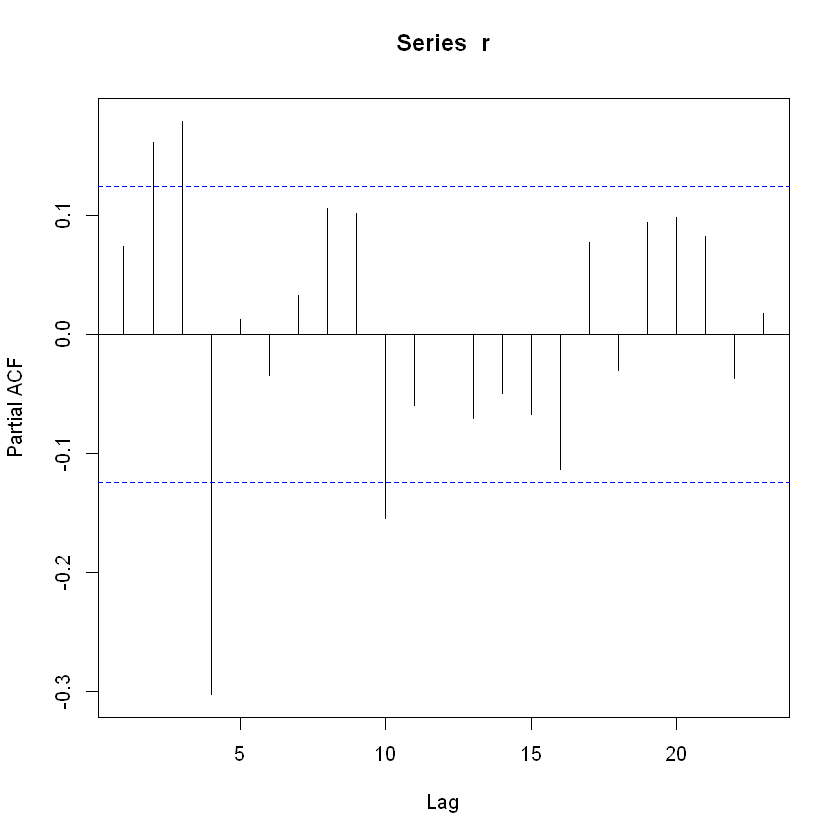

In [12]:
pacf(r); #partial autocorrelation function

In [13]:
Box.test(r,lag = log(length(r)),type="Ljung-Box")


	Box-Ljung test

data:  r
X-squared = 33.084, df = 5.5215, p-value = 6.269e-06


We have already the idea that our return are not white noise, we use this this analysis to confirm it.\\
We see that in both graphics there are some spikes, more precisely, in the pacf's graph, we see that we have the higher values in 2,3,4 and 10, so we will use this lags for our future analysis.\\
Finally we look at the results from the Box.test to confirm that our data are not White Noise.\\

Firstly we use the Akaike's information criterior to choose the number of parameters for our autoregressive model, then we find the characteristic roots of the equation.

In [8]:
ar(r)$aic
M=Arima(r,order = c(10,0,0))
Arima(r,order = c(4,0,0))

roots = polyroot(c(1,-M$coef[1:10])) 
croots = 1/roots
Mod(croots)

0           1           2           3           4           5 
32.12326907 32.74308782 28.18778118 22.05297022  0.06473416  2.02691161 
          6           7           8           9          10          11 
 3.73155886  5.46344913  4.63953766  4.05553831  0.00000000  1.10013775 
         12          13          14          15          16          17 
 3.10012213  3.83966095  5.21920531  6.08313075  4.84171415  5.35484336 
         18          19          20          21          22          23 
 7.12759306  6.91401615  6.50799640  6.80794439  8.45961565 10.38524527

Series: r 
ARIMA(4,0,0) with non-zero mean 

Coefficients:
         ar1     ar2     ar3      ar4    mean
      0.0897  0.1973  0.1898  -0.3033  2.8572
s.e.  0.0601  0.0593  0.0592   0.0602  1.2349

sigma^2 estimated as 265.3:  log likelihood=-1050.09
AIC=2112.17   AICc=2112.52   BIC=2133.3

[1] 0.8605365 0.8944716 0.8944716 0.8605365 0.8419926 0.8410988 0.8419926
 [8] 0.7601713 0.7601713 0.8410988

We see that the number of our parameter is 10 and that the modulus of our characteristic roots is always smaller than 1, so our series is stationary. In the end we analyse the residuals.\\ 

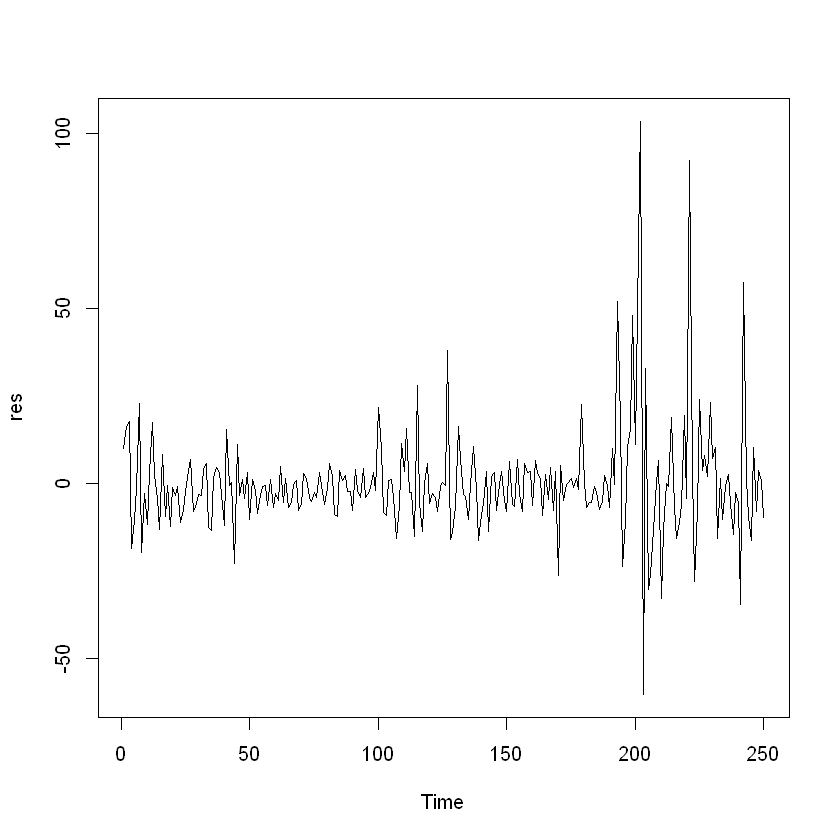

In [16]:
res = M$residuals
plot(res)

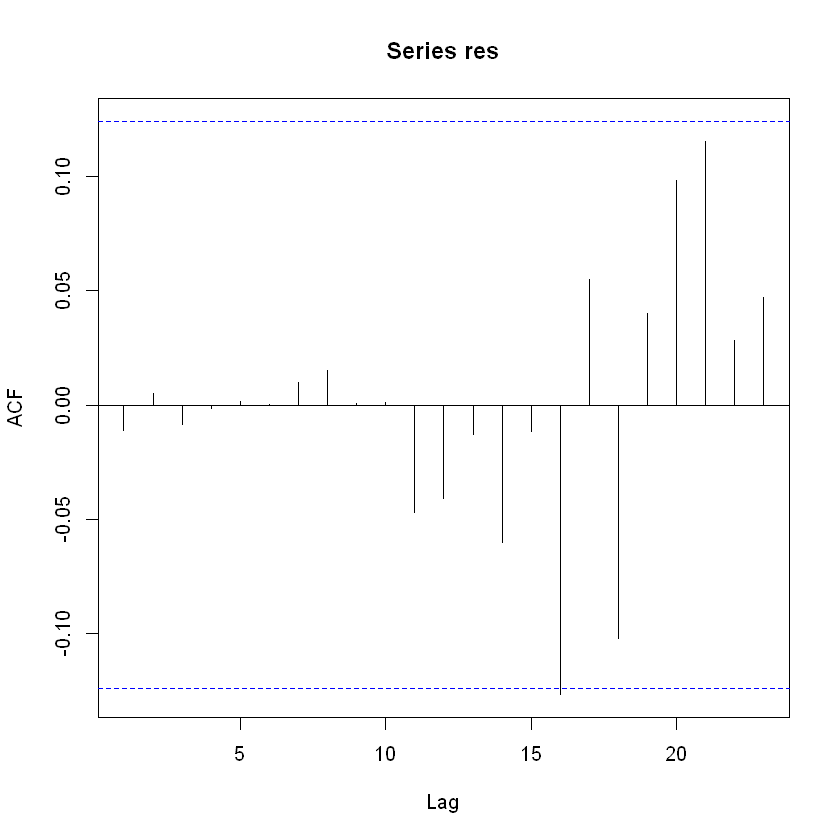

In [17]:
acf(res)


	Box-Pierce test

data:  res
X-squared = 17.451, df = 15, p-value = 0.2926



Title:
 Jarque - Bera Normalality Test

Test Results:
  STATISTIC:
    X-squared: 2331.6508
  P VALUE:
    Asymptotic p Value: < 2.2e-16 

Description:
 Sun Jan 23 17:38:19 2022 by user: Mattia


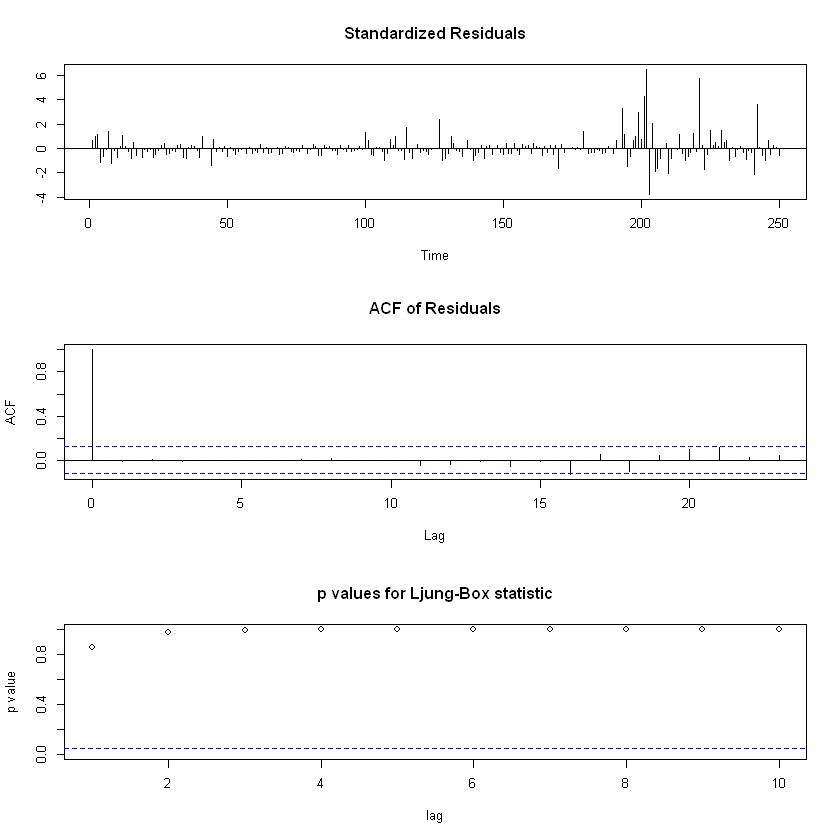

In [18]:
Box.test(res,lag = 25, fitdf=10)
tsdiag(M)
normalTest(res,method="jb")

We can see that they are not a serially correlated sequence, and they not normally distributed.

To conclude the project, we will use the function predict to forecast our series.

pred :  Time-Series [1:10] from 241 to 250: 0.326 -2 -1.123 6.056 2.85 ...
se :  Time-Series [1:10] from 241 to 250: 15.7 15.8 16.2 16.8 17 ...

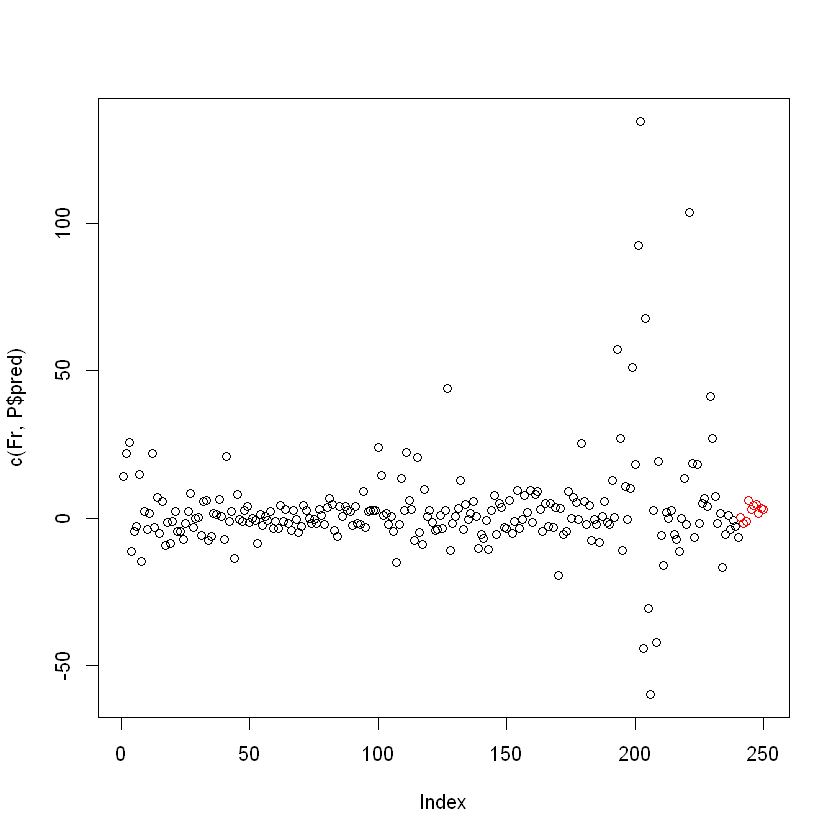

In [19]:
T=length(r)
t=T-10
Fr=r[1:t]
FM=Arima(Fr,order = c(10,0,0))
P = predict(FM,10)                           
ls.str(P)                                      
plot(c(Fr,P$pred))
points(c(rep(NA,240),P$pred),col="red")

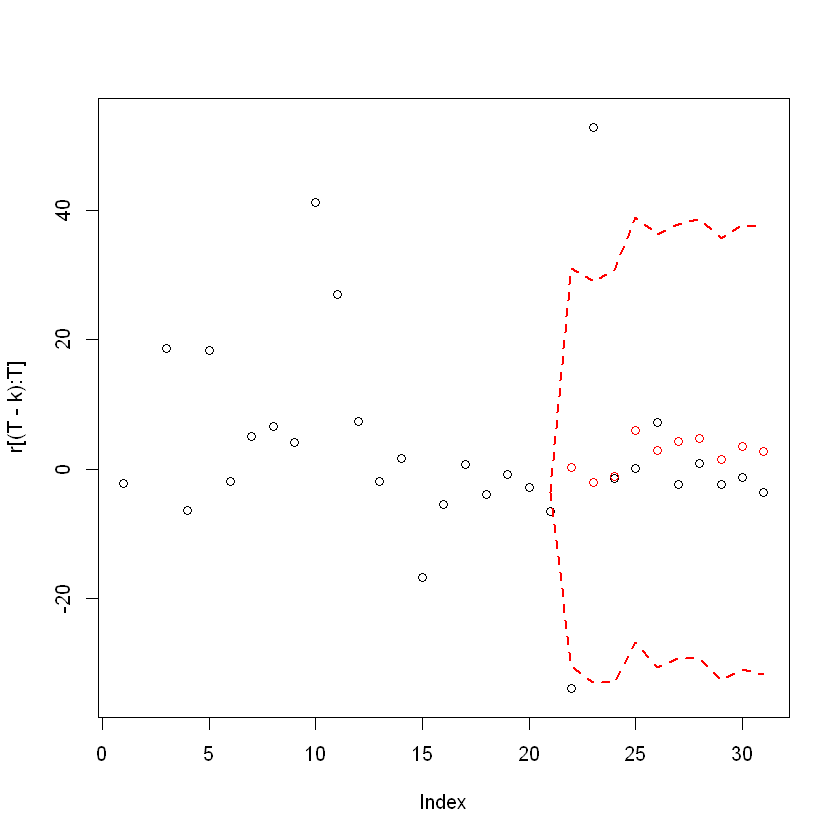

In [20]:
MR=max(r[t:T])
mR=min(r[t:T])

k = 30;
plot(r[(T-k):T],ylim=c(mR-1,MR+1))
points(c(rep(NA,k-10+1),P$pred),col="red")
lines(c(rep(NA,k-10),x[T],P$pred+1.96*P$se),col="red",lwd=2,lty=2)
lines(c(rep(NA,k-10),x[T],P$pred-1.96*P$se),col="red",lwd=2,lty=2)

In the end we can see that, except from the first two data, the other one are similar and inside the prediction interval of 95\%. \\
I don't think that this prediction model is good. It is good when the behaviour is constant but when the returns get strange value then the prediction is completely wrong